# Pairwise Query Similarity with Jaccard Similarity

The aim of this experiment is to find similar descriptions from the pool of descriptions present to the given input. This can be achieved in many ways and the main four ways experimented here are: 

        - Calculating Jaccard Similarity between entity classes. 
        - Using Word2Vec embeddings and Cosine similarity between descriptions 
        - Using sentence transformers for the caluclation of similarities. 

- This notebook in particular deals with <b>Cosine Similarity Calculated using Word2Vec Embeddings</b> 

- It also contains the description about how many top 3 similar queries have the same decade and author. <b>(Task for the DSTrack)</b>

- There is also a runtime measurement that has been done with respect to these queries. 







Importing Libraries necessary

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
import pickle 
import time
import seaborn as sns
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize 
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance

### The Dataset

The Different Attributes in the dataset are: 
- id : text 
- Artist : text 
- Album : text 
- Decade : text 
- Sales_total : number 
- Sales_US : number
- <b>Description : Text</b>

In [2]:
dataset = pd.read_csv('../data/preprocessed.csv') 
dataset.head(3)


,id,artist,album,decade,sales_total,sales_us,description,author
0,25-the-beatles-sgt-pepper-s-lonely-hearts-club...,The Beatles,Sgt. Pepper’s Lonely Hearts Club Band,60s,1800000,1100000,decade defined sweeping cultural paradigm shif...,Max Blau
1,24-pink-floyd-the-wall,Pink Floyd,The Wall,70s,1800000,1100000,legacy pink floyd cemented dark side moon . wa...,Clint Alwahab
2,23-michael-jackson-bad,Michael Jackson,Bad,80s,1900000,1000000,bizarre consider album five consecutive number...,Josh Jackson


### Working with word2vec 

Word2Vec is a word embedding that maps words to vectors. Ideally the way to calculate similarity would be to use convert words in the descriptions and then obtain the word embeddings for the same. 

Since word2vec can only give the similarity between two words, the word vectors for the words in the description are averaged out to calculate the cosine similarity. 

In [82]:
description = list(dataset['description'])


In [83]:
def tokenize_description(query):
    '''
    Function takes in query 
    tokenizes and returns the entire list of strings 
    '''
    word_tokens = word_tokenize(query) 
    return word_tokens


In [84]:
'''
Creating a word2vec model using the tokenized description of words using CBOW 
'''
tokenized_descriptions = [tokenize_description(sentence) for sentence in description] 
word2vec = Word2Vec(tokenized_descriptions, min_count = 1, window = 5)

Now that a model has been constructed over the corpus that is present within the descriptions, we need to compute average vectors for the sentences in the corpus to assess the similarity between them. 


In [85]:
def compute_avg_vectors(tokenize_description, num_features): 
    '''
    Takes in the tokenized version of the description 
    Returns the average vector by considering all the words present in the sentence. 
    '''
    vector = np.zeros((num_features,), dtype='float32')
    no_of_words = 0 
    for word in tokenize_description:
        if word in word2vec.wv:
            no_of_words+=1
            vector = np.add(vector, word2vec.wv[word])
        if no_of_words>0:
            vector = np.divide(vector, no_of_words)
        return vector

def cosine_similarity(vec1, vec2):
    f = compute_avg_vectors(vec1, 100)
    g  = compute_avg_vectors(vec2, 100)
    cosine = 1-distance.cosine(f,g) 
    return cosine 
    
def cosine_similarity_calculator(query):
    '''
    Function that takes in one query 
    * Calculates the average vector for the query 
    * Compares it with the average vectors of all the descriptions. 
    * returns an array containing the cosine similarity value 
    '''
    cosine_similarity_values = [] 
    
    for i in range(1, len(tokenized_descriptions)):
        
        cosine_similarity_values.append((cosine_similarity(query, tokenized_descriptions[i]),i))
    
    return cosine_similarity_values



#### Calculation of Cosine Similarity using Word2Vec Embeddings

Cosine similarity indicates the cosine between the two vectors in space. It's a <b>1</b> if both the vectors are similar and a <b>0</b> if the vectors aren't similar. 

Nearer 1, indicates more similarity. 


In [86]:
'''
Calculating the cosine similarity or all the descriptions. 
Time taken for the comparisons and calculations of similarity is measured too 
'''

start = time.time()
cosine_similarity_matrix = [] 

for i in range(len(tokenized_descriptions)):
    cosine_similarity_matrix.append(cosine_similarity_calculator(tokenized_descriptions[i]))

end = time.time() 
print("Runtime Value for Cosine Similarity Comparisons using Word2Vec: ", round(end-start, 3), ' seconds')

Runtime Value for Cosine Similarity Comparisons using Word2Vec:  0.042  seconds


This is how the cosine similarity matrix looks like 

In [87]:
dataframe = pd.DataFrame(cosine_similarity_matrix)
dataframe.head(3) 

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,"(0.13970878720283508, 1)","(-0.037503208965063095, 2)","(0.05302009731531143, 3)","(0.06289706379175186, 4)","(-0.014186019077897072, 5)","(0.1128498762845993, 6)","(-0.0609397254884243, 7)","(-0.03531228378415108, 8)","(0.015182177536189556, 9)","(-0.18590465188026428, 10)",...,"(0.06984648108482361, 15)","(-0.248823344707489, 16)","(0.07412952929735184, 17)","(-0.04449101909995079, 18)","(-0.174117773771286, 19)","(-0.026812352240085602, 20)","(-0.05553707852959633, 21)","(0.03755660727620125, 22)","(-0.2613500952720642, 23)","(0.06849230080842972, 24)"
1,"(1, 1)","(0.02754221111536026, 2)","(-0.029957015067338943, 3)","(-0.27696654200553894, 4)","(-0.05993315577507019, 5)","(-2.1929447029833682e-05, 6)","(-0.028983842581510544, 7)","(-0.05286146700382233, 8)","(0.10397811979055405, 9)","(0.10458412021398544, 10)",...,"(0.023049406707286835, 15)","(-0.1958296149969101, 16)","(0.0017322857165709138, 17)","(-0.14578202366828918, 18)","(-0.14239908754825592, 19)","(-0.00846912618726492, 20)","(0.09922327846288681, 21)","(-0.06321217864751816, 22)","(-0.055664703249931335, 23)","(0.1326041966676712, 24)"
2,"(0.02754221111536026, 1)","(1, 2)","(-0.03819708153605461, 3)","(-0.08200433850288391, 4)","(-0.03386588394641876, 5)","(0.13592404127120972, 6)","(0.023264823481440544, 7)","(0.001704794936813414, 8)","(-0.003120281035080552, 9)","(0.09831743687391281, 10)",...,"(-0.11867132782936096, 15)","(-0.10796932876110077, 16)","(0.07677129656076431, 17)","(0.21501335501670837, 18)","(0.08162051439285278, 19)","(-0.055775709450244904, 20)","(-0.10007375478744507, 21)","(0.018860867246985435, 22)","(0.054054681211709976, 23)","(0.007356402464210987, 24)"


### Analyzing authors and decades

Analyzing authors and decade information for the top 3 most similar queries for every description value to calculate a percentage of queries that have this property. 

In [88]:
def get_top_3(cosine_value_list):
    '''
    Takes in the cosine similarity value list
    Returns the index of the top 3 similar queries
    '''
    cosine_value_list = sorted(cosine_value_list)
    cosine_value_list = cosine_value_list[len(cosine_value_list)-3:]
    indices = [ value[1] for value in cosine_value_list]
    return indices

def check_similar_authors(similar_query_indices):
    '''
    Takes the indices of the top 3 similar queries
    Returns the percentage of similar authors
    '''

    if dataset.iloc[similar_query_indices[0]].author == dataset.iloc[similar_query_indices[1]].author == dataset.iloc[similar_query_indices[2]].author:
        return 3/3 
    if dataset.iloc[similar_query_indices[1]].author == dataset.iloc[similar_query_indices[2]].author or dataset.iloc[similar_query_indices[2]].author == dataset.iloc[similar_query_indices[0]].author or dataset.iloc[similar_query_indices[1]].author == dataset.iloc[similar_query_indices[0]].author:
        return 2/3
    return 0/3
    
def check_similar_decade(similar_query_indices):
    '''
    Takes the indices of the top 3 similar queries 
    Returns the percentage of similar decades
    '''
  
    
    if dataset.iloc[similar_query_indices[0]].decade == dataset.iloc[similar_query_indices[1]].decade == dataset.iloc[similar_query_indices[2]].decade:
        return 3/3
    if dataset.iloc[similar_query_indices[1]].decade == dataset.iloc[similar_query_indices[2]].decade or dataset.iloc[similar_query_indices[2]].decade == dataset.iloc[similar_query_indices[0]].decade or dataset.iloc[similar_query_indices[0]].decade == dataset.iloc[similar_query_indices[1]].decade:
        return 2/3
  
    
    return 0/3

In [89]:
#Getting the top 3 most similar queries for each description.  
get_top_3_indices = [get_top_3(cosine_similarity_matrix[i]) for i in range(len(cosine_similarity_matrix))] 

#Getting the percentage of same authors  in the top 3 most similar albums (based on description)
same_author_percentage = [check_similar_authors(index) for index in get_top_3_indices]

#Getting the percentage of same decade for top 3 most similar album (based on description)
same_decade_percentage = [check_similar_decade(index) for index in get_top_3_indices]

 

### Visualization of Results of percentage of same decades and authors within top 3 most similar queries

##### Histogram to understand the distribution of queries that had 1author similar in the top 3 queries, 2 authors similar in the top 3 queries 

Text(0, 0.5, 'Frequency')

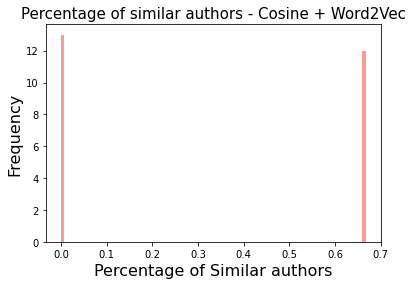

In [94]:

hplot = sns.distplot(same_author_percentage, kde=False, color='Red', bins=100)
plt.title('Percentage of similar authors - Cosine + Word2Vec', fontsize=15)
plt.xlabel('Percentage of Similar authors', fontsize=16)
plt.ylabel('Frequency' , fontsize=16)

> Conclusion: 
- 13 albums do not have any of the top 3 similar albums sharing any similarity in the authors of the description. 
- 12 albums have two of the authors being similar between the top 3 most similar album queries. 

##### Histogram to understand the distribution of queries that had 1 decade similar in the top 3 queries, 2 decades similar in the top 3 queries 

Text(0, 0.5, 'Frequency')

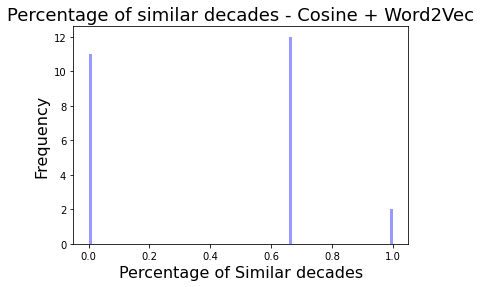

In [95]:
hplot = sns.distplot(same_decade_percentage, kde=False, color='blue', bins=100)
plt.title('Percentage of similar decades - Cosine + Word2Vec', fontsize=18)
plt.xlabel('Percentage of Similar decades', fontsize=16)
plt.ylabel('Frequency' , fontsize=16)

> From the above histogram, it can be observed that 
- around 11 albums, do not have any similarity in decades between their top 3 most similar albums. 
- 12 albums have 3 of the top 3 most similar albums having the same decades. 
- 2 albums have all the top 3 most similar queries having the same decade. 
